# Importation des Librairies Utiles

In [1]:
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pymongo
import numpy as np 
import math

#### Fonction optimisant le calcul du silhouette score 

# Importation des données

Nos données sont toutes stockées dans une base de donnée mongoDB. Afin de pouvoir importer nos données pour pouvoir les traiter, nous devons donc nous connecter à la base de donnée **Tweet** puis à sa collection **`users`**.


In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["Tweet"]
user_collection = db["users_scaled"]

# Récupération des données

Afin d'avoir la main sur les données et rendre plus souple la manipulation, nous importons toutes les données dans un objet de type `dataframe` grâce à la librairie `pandas`

In [3]:
users = list(user_collection.find({}))
users = pd.DataFrame(users)

## Suppression des colonnes non utilisées lors du kmeans

les variables `_id`, `last_tweet_published_id`,`tweet_ids` sont de referneces qui ous ont permis d'extraires les atributs de nos utilisateurs. Elles n'etant plus très necessaire  par la suite nous alons les suprimés
 
On retire toutes les colonnes qui ne sont pas des attributs de nos utilisateurs.  
De plus supprime l'attribut tweet_frequency de nos données sachant qu'il est corrélé avec l'agressivité. Ce paramètre n'apporte pas d'informations supplémentaires. Une visualisation de cette corrélation peut être observée dans le script ``previewData``

In [4]:
users.columns

Index(['_id', 'hashtag_frequency', 'verified', 'statuses_count',
       'favourites_count', 'friends_count', 'followers_count', 'age_account',
       'ratio_friends_followers', 'avg_tweet_length', 'tweet_frequency',
       'nb_sensitive_tweets', 'Ap', 'visibility', 'ratio_sensitive_tweets',
       'ratio_punctuation_tweets', 'avg_tweet_levenshtein_similarity',
       'user_id'],
      dtype='object')

In [5]:
users = pd.DataFrame(users)
users.index = users.user_id
users = users.drop(columns=["_id","user_id","avg_tweet_length","tweet_frequency","hashtag_frequency","avg_tweet_length"])
users.head()
%store users

Stored 'users' (DataFrame)


## Réalisation de l'ACP


In [6]:
# Instansiation de la classe PCA en objet pca
pca = PCA()

In [7]:
result = pca.fit_transform(users)
nb_attributes = users.shape[1]

Stockage du résultat de l'ACP dans un dataframe avec les noms de colonnes CP1, CP2... CP1 = composante 1

In [8]:
n,m = users.shape
cp_liste = []
for i in range(1,nb_attributes+1):
    cp_liste.append(f"CP{i}")
result = pd.DataFrame(result, columns = cp_liste)
%store cp_liste

Stored 'cp_liste' (list)


### Détermination des valeurs propres


La variance calculé avec le module `PCA` est celle donnée par l'estimateur sans biais  definie par la formule $\sigma^2 = \frac{1}{n-2}\sum_ {i=1}^ {n} (x_i -\bar{x})^2  $ 

Un ajustement est nécessaire pour avoir la variance avec n degrés de liberté.

In [9]:
variance = pca.explained_variance_
# Un ajustement est nécessaire pour avoir la variance avec n degrés de liberté
eigval = variance*(len(users)-1)/len(users)  
print(eigval)
print(f"Et on a la somme des valeures propre egale  à :{np.sum(eigval, axis =0)}")

[2.02647268 1.3585601  1.28829485 1.15041457 1.03019743 1.00012384
 0.94103806 0.87860271 0.85600667 0.8036528  0.73309372 0.64188481
 0.29165776]
Et on a la somme des valeures propre egale  à :13.000000000006136


### Détermination du nombre de dimensions à retenir
#### Diagramme en Bar de valeurs propres
Afin de pouvoir choisir le nombre de composantes à retenir, Nous allons d'abord nous interesser au diagramme en Bar des valeurs propre. Mathematiquement une valeure propre nulle implique que la dimension qui est portée par cette valeur propre ne conserve aucune information sur les données d'origine.

Ainsi,nous effectuons le diagramme des valeurs propres Rangées dans l'ordre decroissant

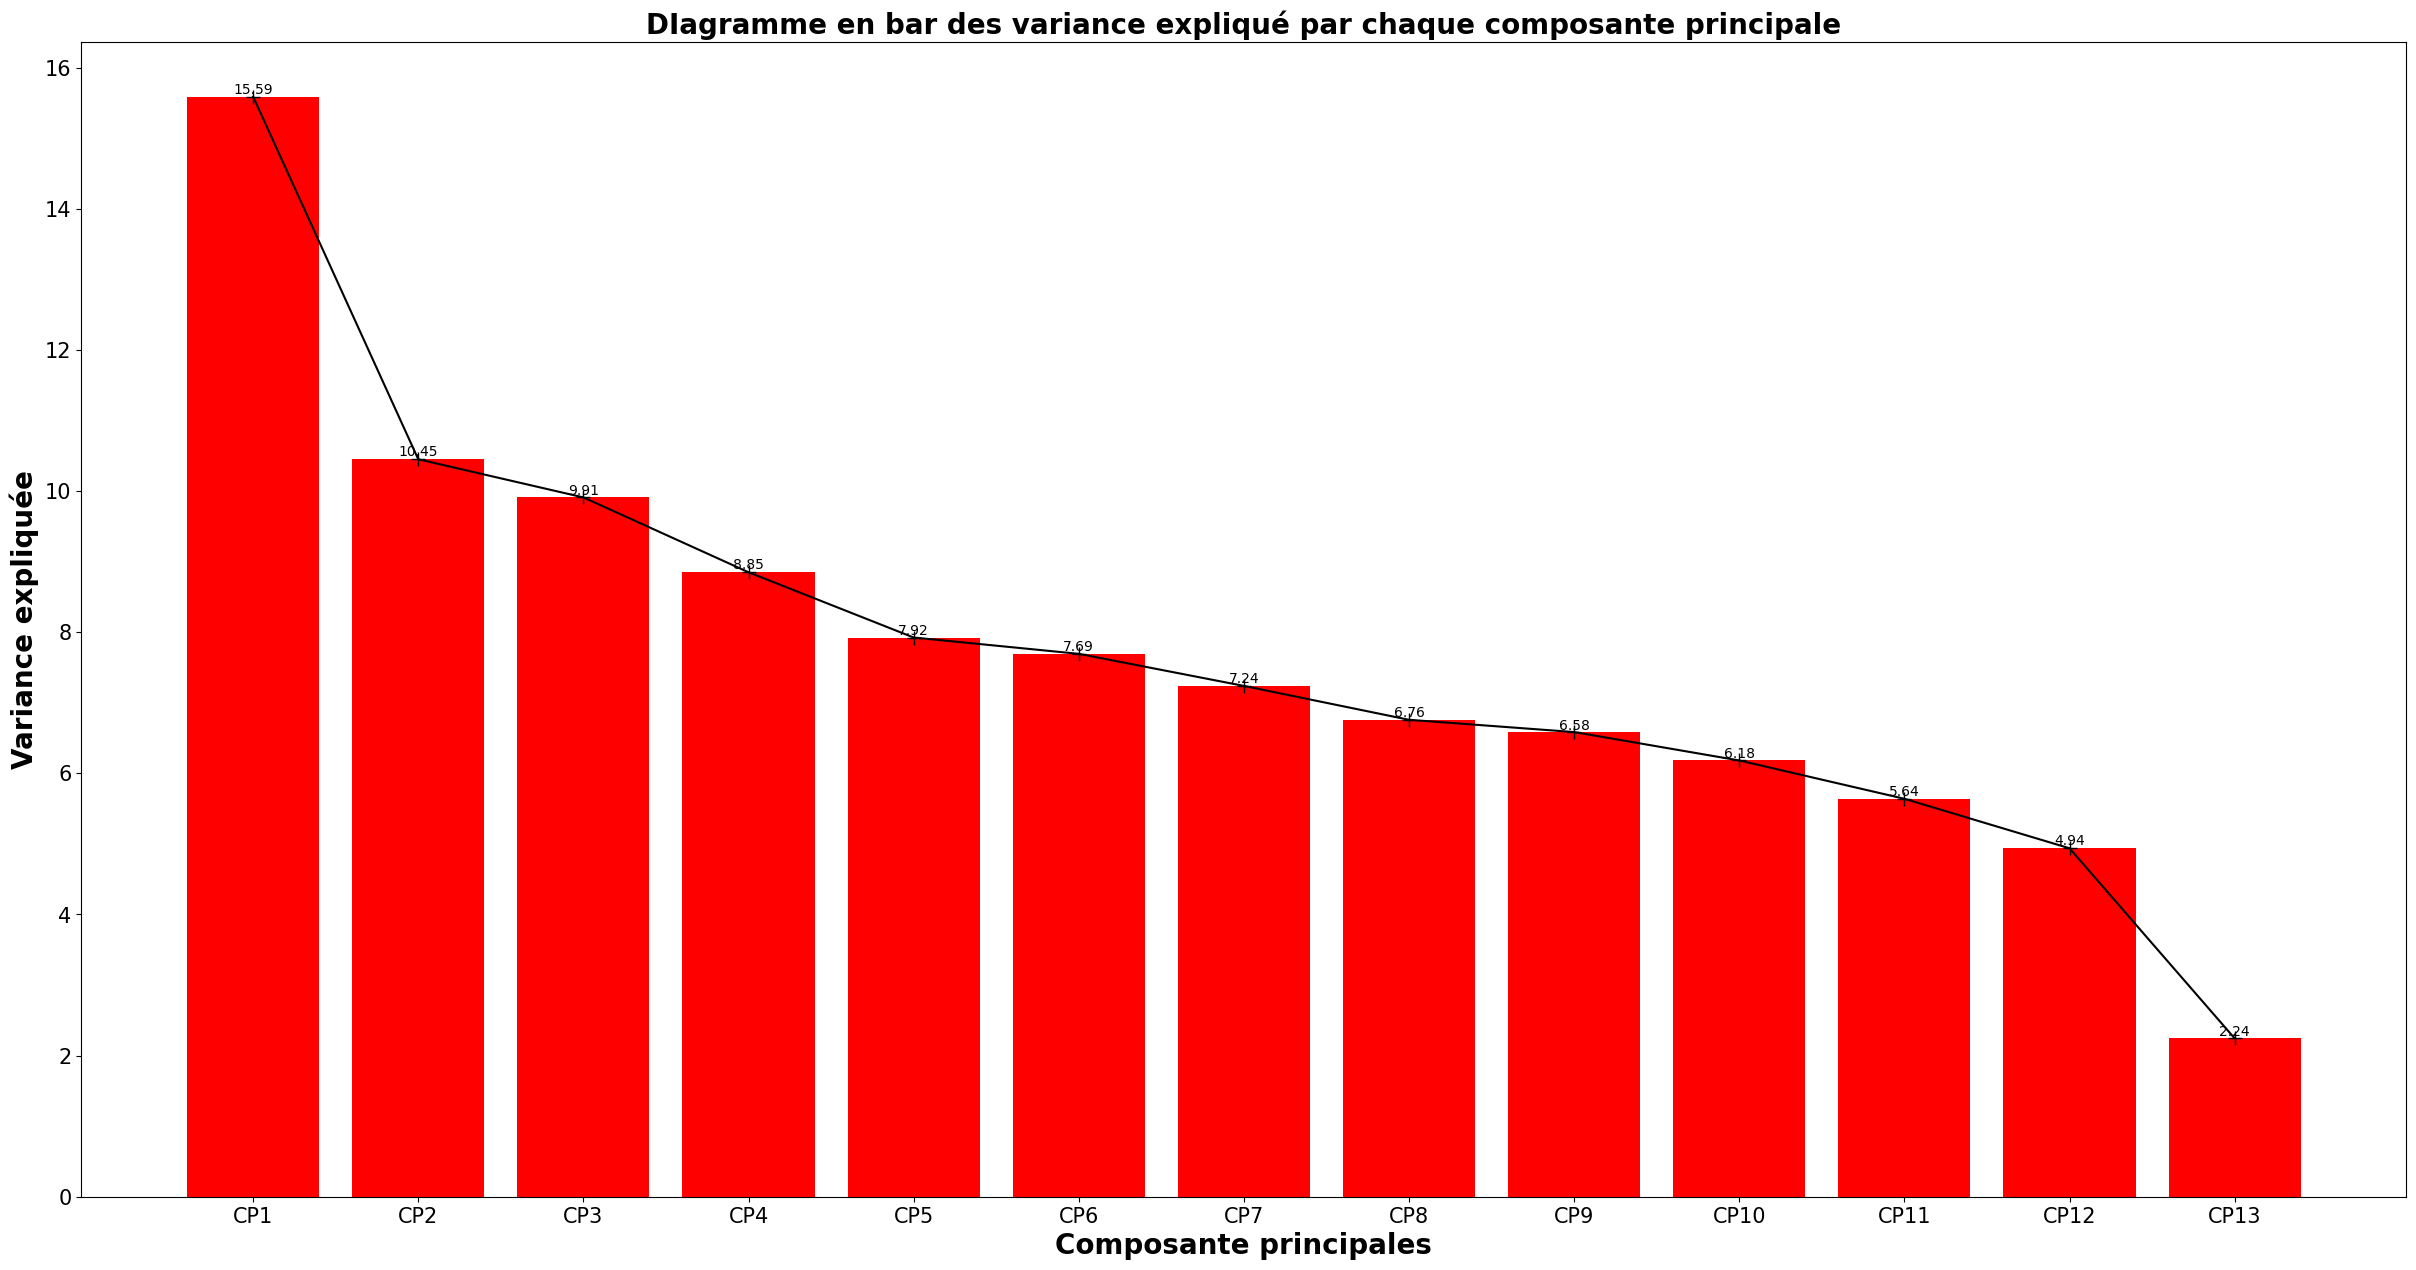

In [10]:
#ratio de la variance expliqué est % vaut 
# sns.barplot(
#     y = 
#     x = cp_liste
# )
#creation de la fiqure et des axes
fig, ax = plt.subplots(figsize=(30, 15))

# On  trace les diagrammes
ax.bar(cp_liste,pca.explained_variance_ratio_*100, color='r')


ax.plot(pca.explained_variance_ratio_*100, marker='+', color='black', ms=10)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)

#enumerzation des valeures sur les bar
for i, v in enumerate(pca.explained_variance_ratio_*100):
    plt.text(i, round(v,2), str(round(v,2)), ha='center', va='bottom')
    
# Affichage des layout
plt.title("DIagramme en bar des variance expliqué par chaque composante principale", fontweight = "bold",fontsize = 20)
plt.xlabel("Composante principales", fontweight = "bold",fontsize = 20)
plt.ylabel("Variance expliquée", fontweight = 'bold',fontsize = 20)
plt.show()

an appliquant le principe de  on peut donc retenir que : .....

## Scree Plot

La regle de coude est Utilisé en Analyse en Composante Pricipales pour determiner le nombre de variables à garder pour l'analyse. Le `Coude` est le point où l'ajout d'une composante supplémentaire ne contribue pas de manière significative à la variance expliquée c'est à dire le point où l'augmentation de la variance expliquée devient moins importante par rapport aux composantes précédentes.

La regle de coude consiste donc à choisir le nombre de variable juste avant le coude

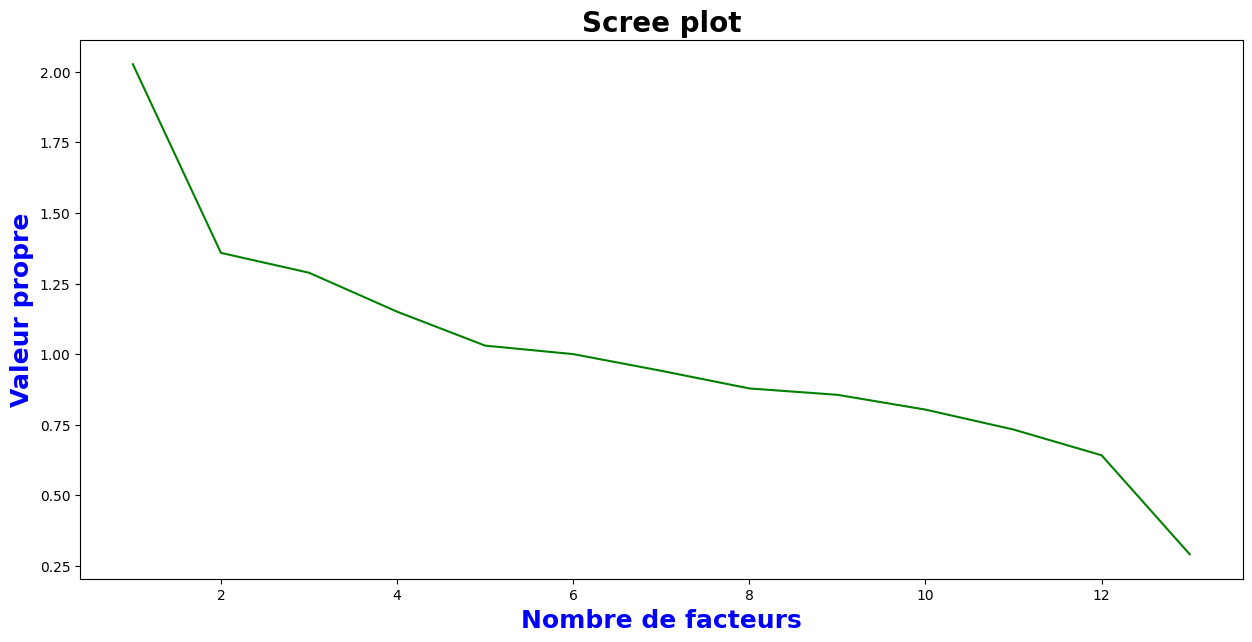

In [11]:
# Scree plot : éboulis des valeurs propres
plt.figure(figsize=(15,7))
plt.plot(np.arange(1,m+1),eigval, color='green')

#Title
plt.title("Scree plot",fontweight = "bold",fontsize= 20)

#Labels
plt.ylabel("Valeur propre", fontweight = "bold",fontsize = 18, color = 'blue')
plt.xlabel("Nombre de facteurs", fontweight = "bold",fontsize = 18, color = 'blue')


plt.show()

L aregle du coude nous permet de ne retenir que .... variables

### Cumul de la variance expliquées par chaques dimensions

Le cumul de la variance expliqué est un indicateurs aussi dans la selection des variables

Ainsi on traçe le graphe du cumul de la variance des valeurs propres, On pourra s'interres aux premierres composantes qui explique le maximum de variances

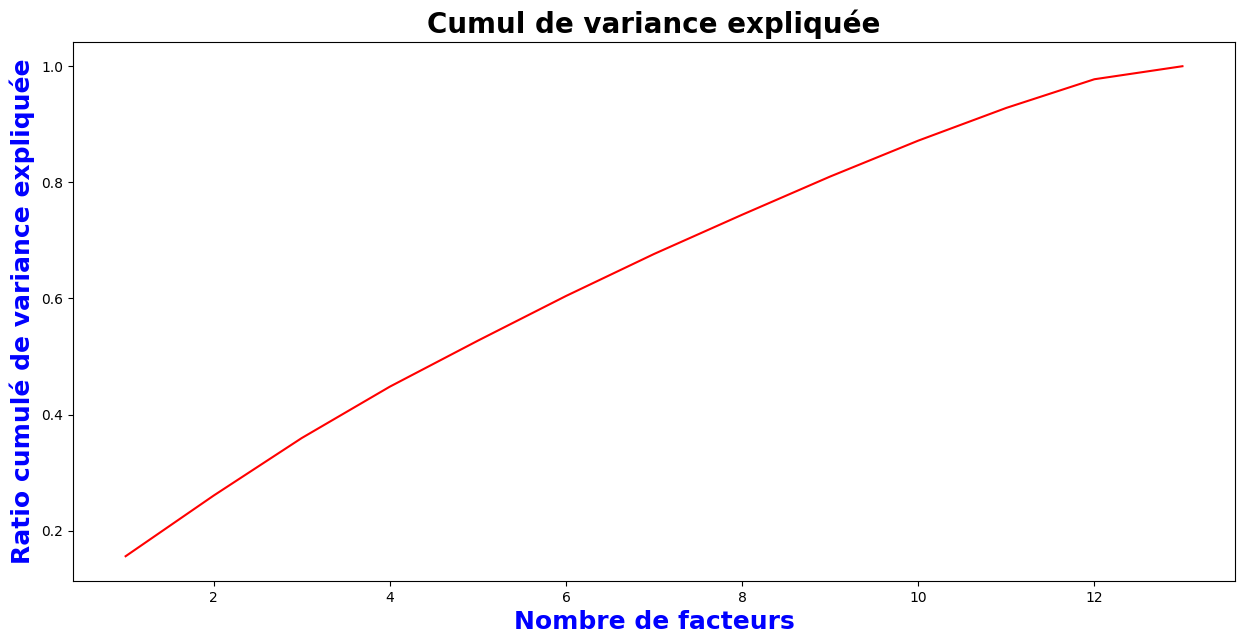

In [12]:
plt.figure(figsize=(15,7))
plt.plot(np.arange(1,m+1),np.cumsum(pca.explained_variance_ratio_),color='red')

#Title
plt.title("Cumul de variance expliquée", fontweight = "bold",fontsize= 20)

# Labels
plt.ylabel("Ratio cumulé de variance expliquée" , fontweight = "bold",fontsize = 18, color = 'blue')
plt.xlabel("Nombre de facteurs" , fontweight = "bold",fontsize = 18, color = 'blue')

# plt.xticks(np.arange(1, m+1))
plt.show()



Ici on obtien environs `90%` de la variances avec 10 variables

### Critère de Kaiser
Un autre critère pour déterminer le nombre de dimensions à retenir est le critère de Kaiser. Selon le principe de Kaiser on peut conserver que les dimensions protées par des valeurs propres supérieures à 1 dans le cas des données centré-réduit.
Puisque nous avons standardisé nos données nous somme légitimme à utiliser ce critère

In [13]:
nb_composante = 0

for valeur_propre in eigval:
    if valeur_propre > 1:
        nb_composante=nb_composante+1


print("le nombre de dimension retenues est : ", nb_composante)
%store nb_composante

le nombre de dimension retenues est :  6
Stored 'nb_composante' (int)


# On reeffectue l'ACP  en tenant en compte les composantes sélectionnées par le critère de Kaiser

In [14]:
acp = PCA(n_components=nb_composante)
acp_coord = acp.fit_transform(users)

### Analyse de l'ACP

In [15]:
# Calcul de la matrice des Valeures Propres
vp_mat= acp.components_.T

# On calcule la racine carrée des valeurs propres
acp_eigvalues = acp.explained_variance_*(len(users)-1)/len(users)
sqrt_eigval = np.sqrt(acp_eigvalues)

# Corrélation des variables avec les axes
corr_var = np.zeros((nb_attributes,nb_composante))
for k in range(nb_composante):
     corr_var[:,k] = vp_mat[:,k] * sqrt_eigval[k]
        
#Construction d'un DataFrame de Correlation
corr_var_df = pd.DataFrame(corr_var)

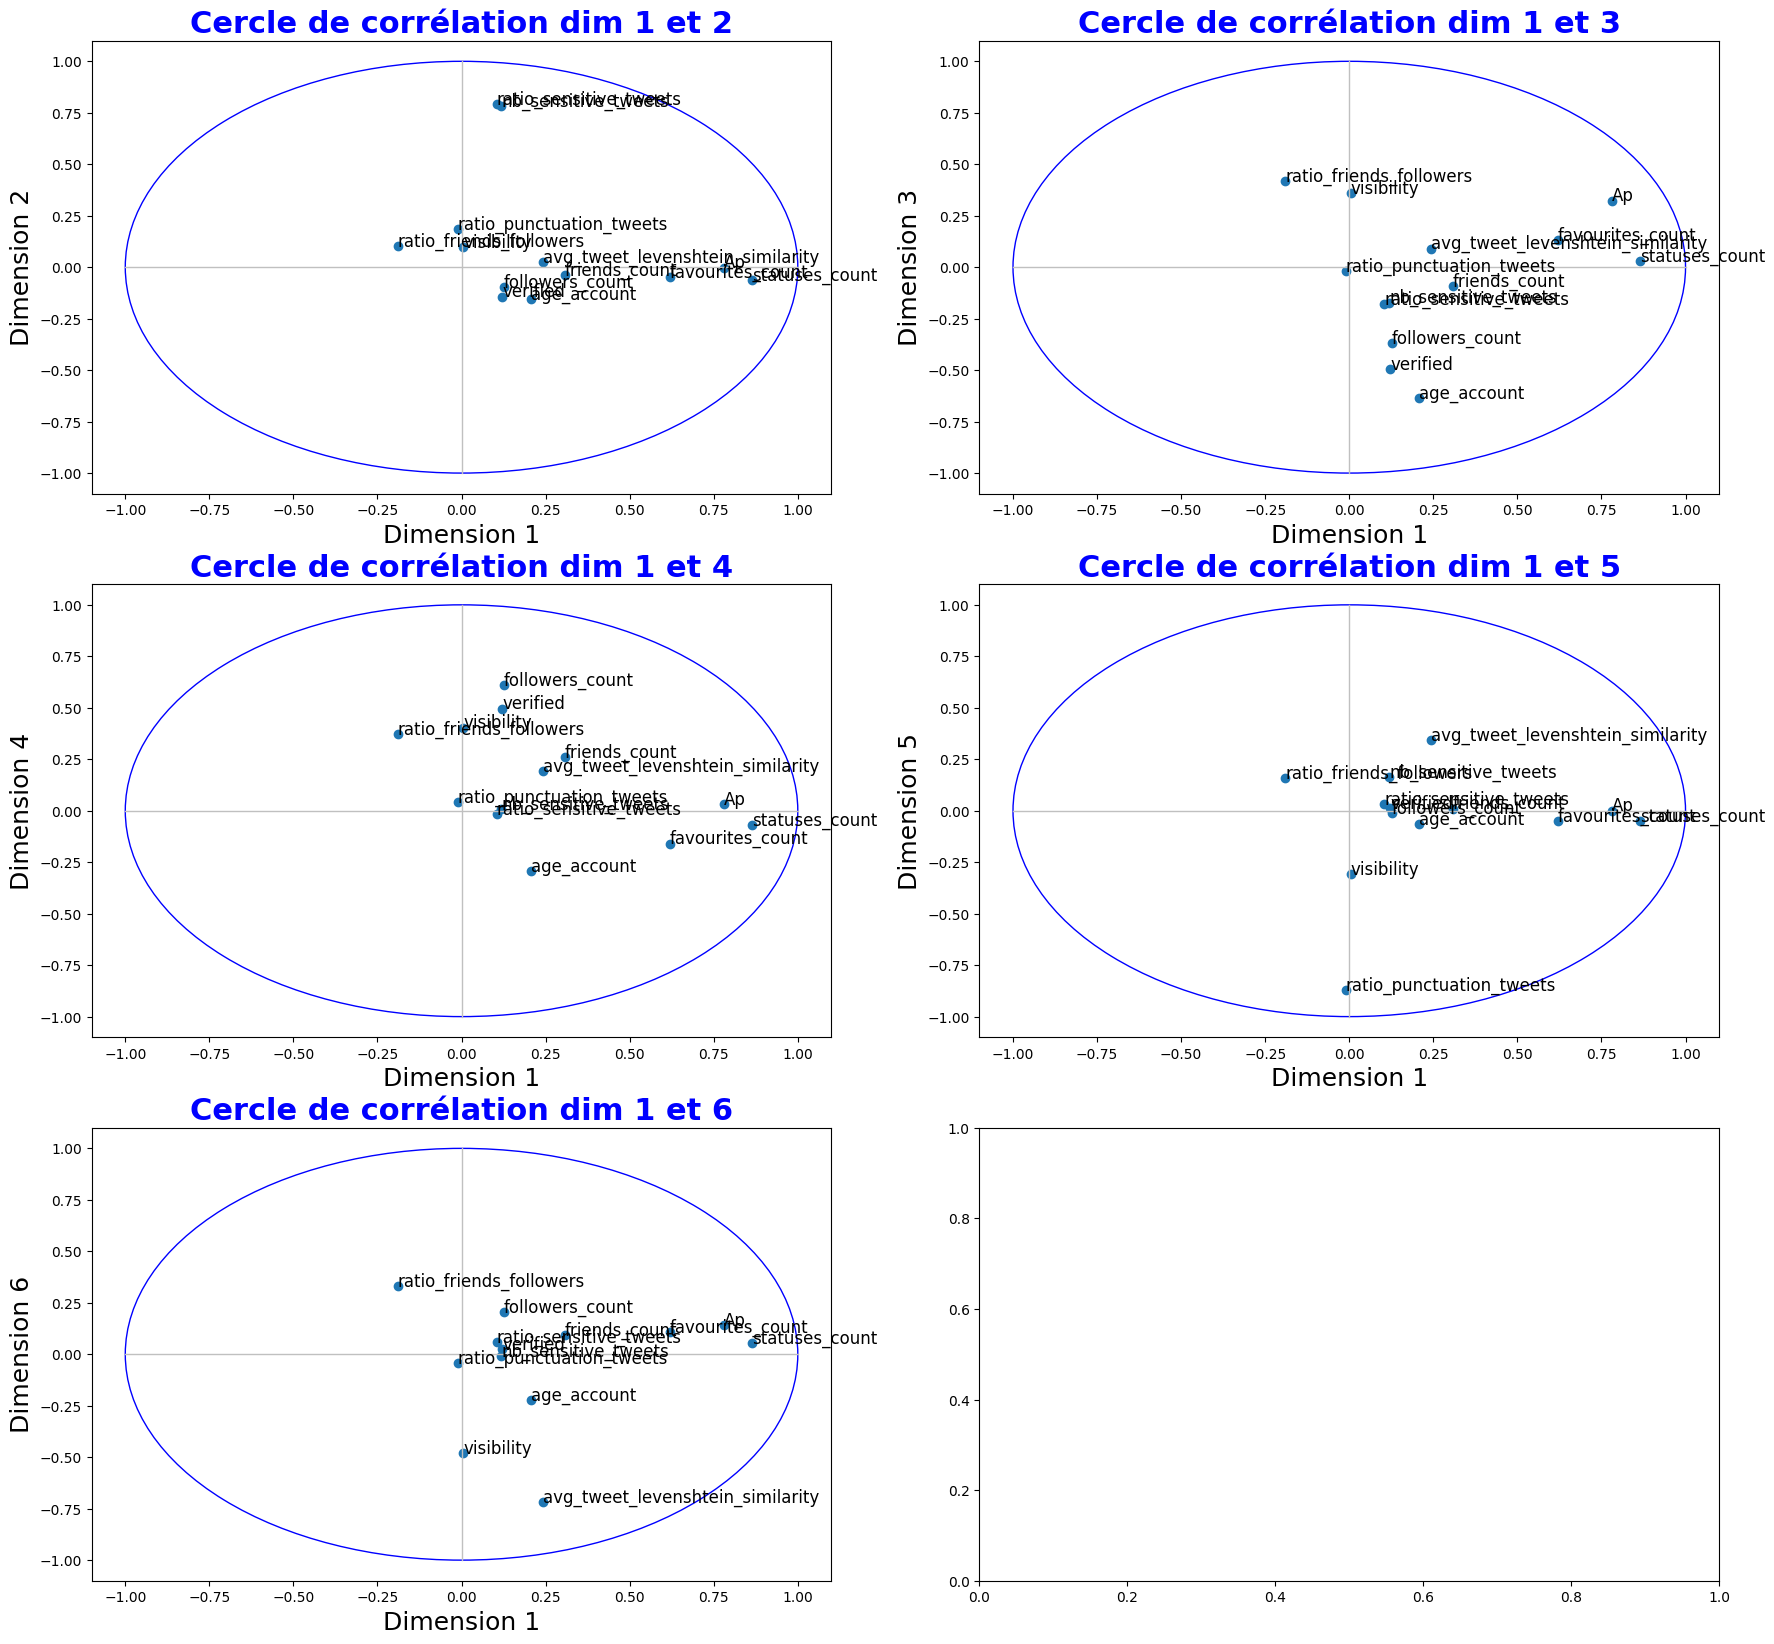

In [16]:
# Cercle des corrélations pour les deux premiers axes

cols = 2
rows = math.ceil( (nb_composante - 1) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(21, 20))

row = 0
col = -1

for dim in range(1, nb_composante):
    col += 1
    # les points
    axes[row][col].scatter(corr_var[:,0],corr_var[:,dim])
    axes[row][col].set_title(f'Cercle de corrélation dim 1 et {dim+1}', fontsize=22, color= 'blue', fontweight='bold')
    axes[row][col].set_xlabel(f'Dimension 1', fontsize=18)
    axes[row][col].set_ylabel(f'Dimension {dim+1}', fontsize=18)

    # affichage des Noms des Variables
    for j in range((len(users.columns))):
        axes[row][col].annotate(users.columns[j],(corr_var[j,0],corr_var[j, dim]), fontsize= 12)

    # ajouter les axes
    axes[row][col].plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
    axes[row][col].plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

    # ajouter le cercle
    cercle = plt.Circle((0,0),1,color='blue',fill=False)
    axes[row][col].add_artist(cercle)
    if col % cols == cols - 1:
        col = -1
        row += 1

#affichage
plt.show()

#### Contributions des variables aux dimensions

$CTR_{jk}$ la contribution de la variable j à la construction de l'axe $k$ est calculée comme suit :

$$CTR_{jk}=\frac{r_{jk}^{2}}{\lambda_{k}}$$

tel que $r_{jk}$ représente la corrélation de la variable $j$ avec l'axe $k$ (que nous avons récupéré dans la variable corvar) et $\lambda_{k}$ represente la valeur propre associée à l'axe $k$.

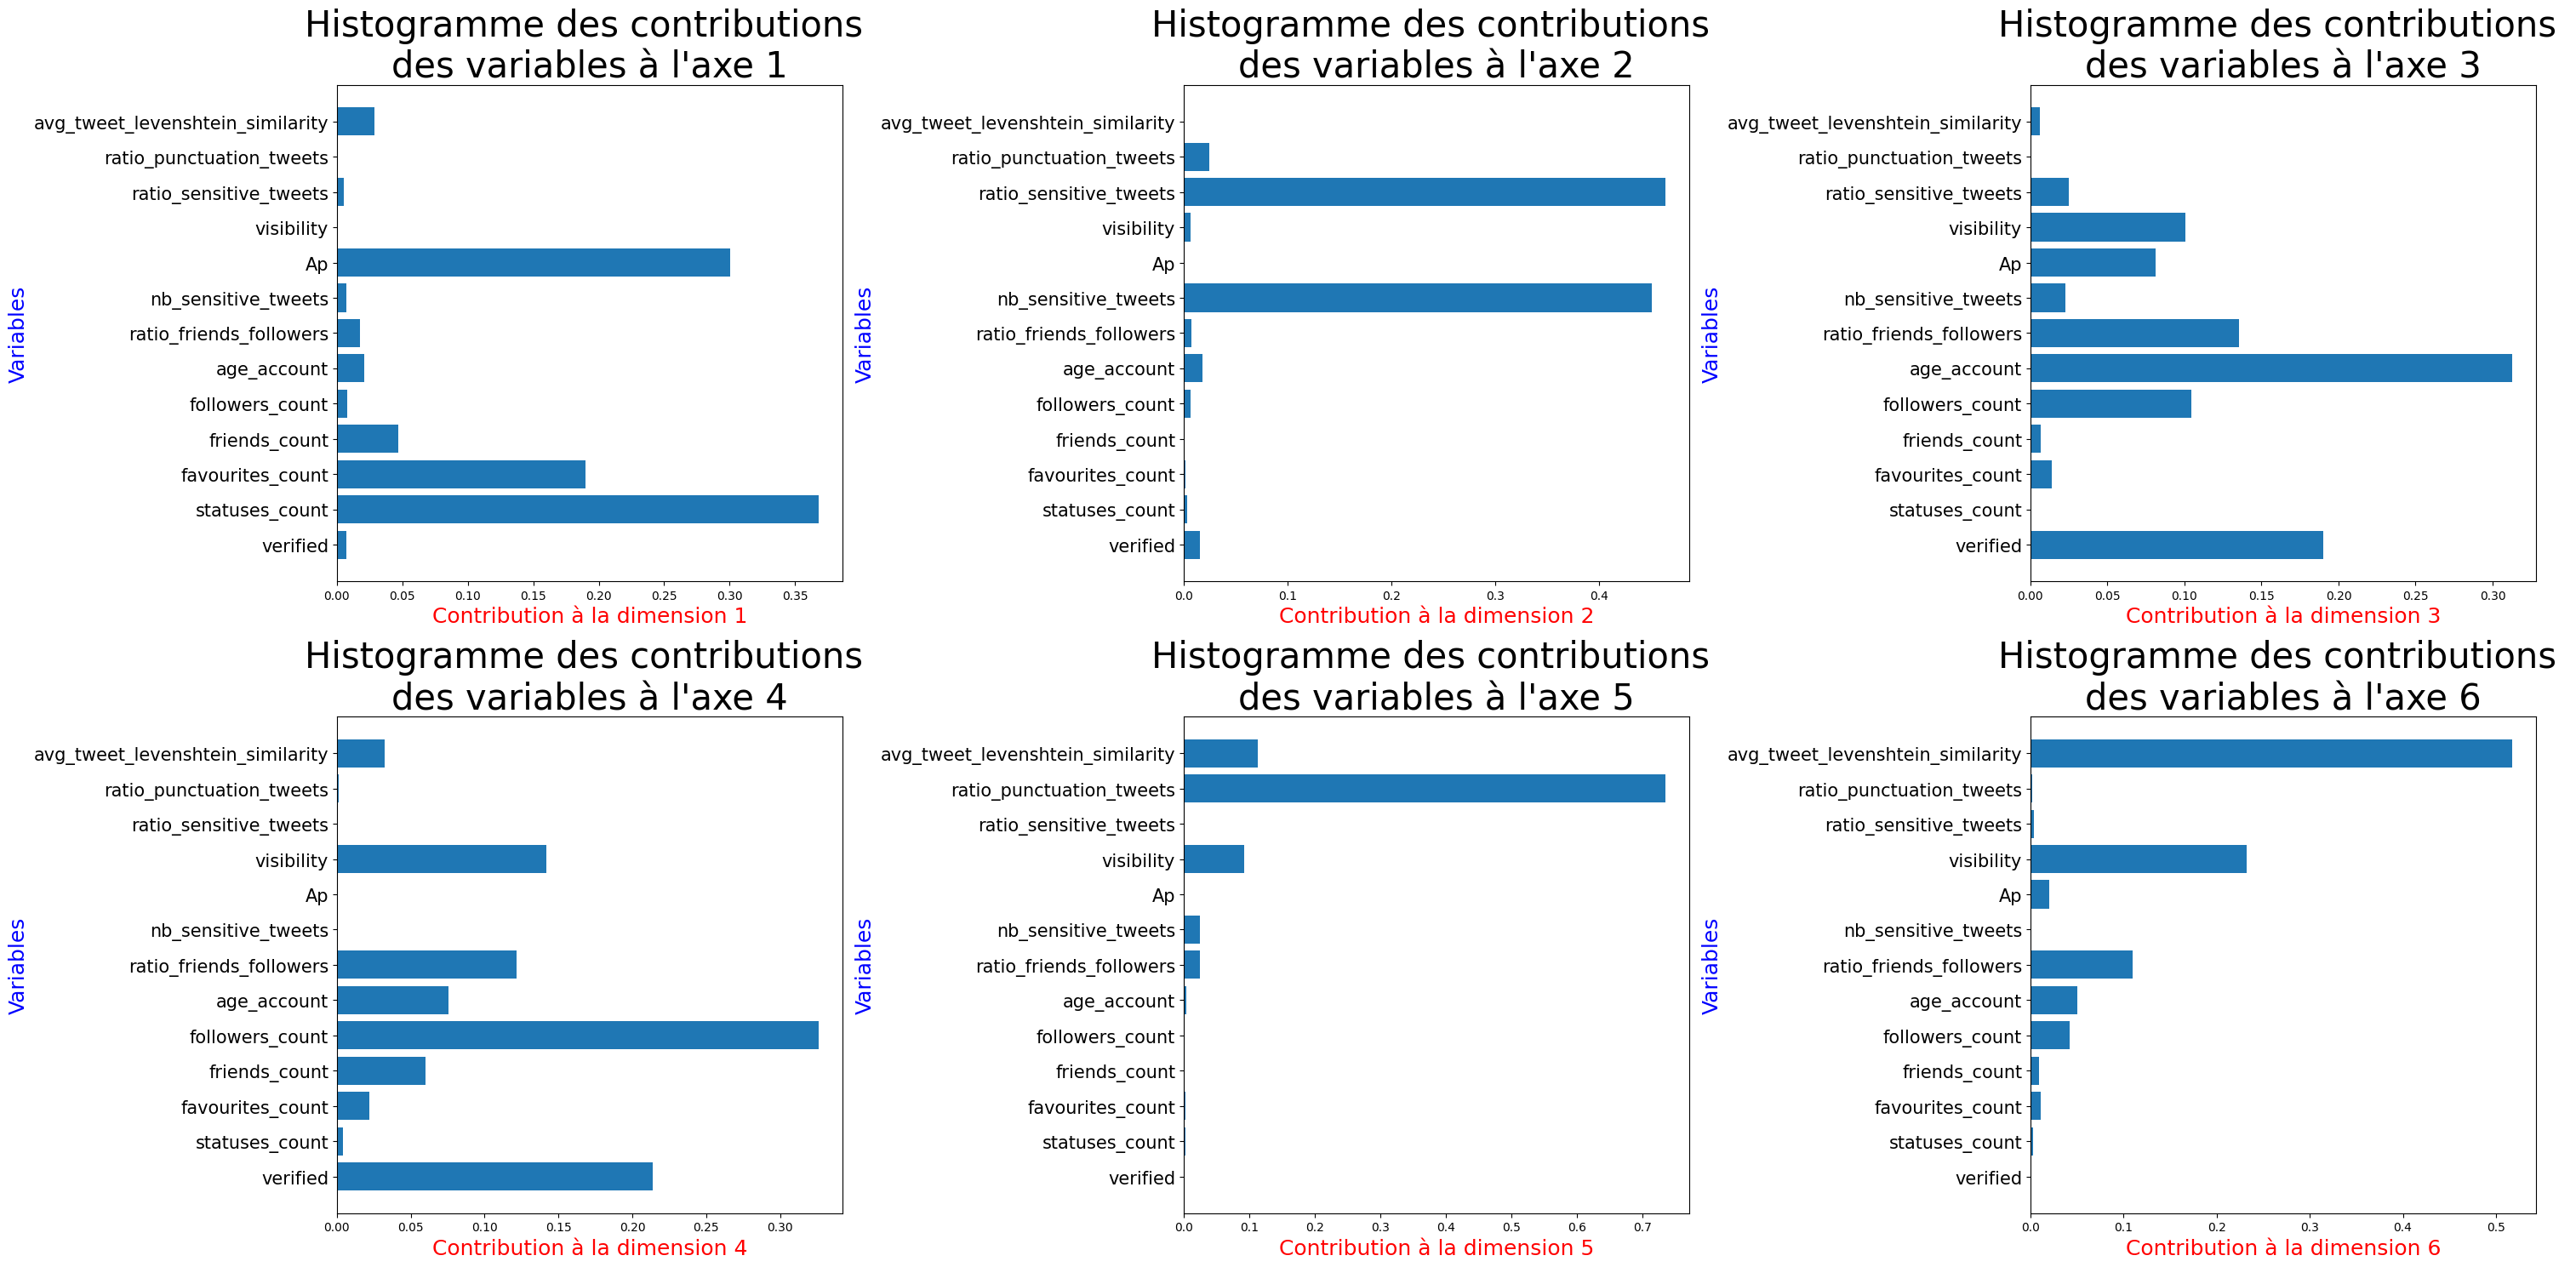

In [17]:
# Calcul des Contributions des variables à la formation des Axes

ctr_var = corr_var**2
for j in range(acp.n_components_):
    ctr_var[:,j]=ctr_var[:,j]/acp_eigvalues[j]


    
# ctr_var_df = pd.DataFrame(ctr_var[:,0:3], columns=['Contribution Axe 1', 'Contribution Axe 2','Contribution Axe 2'],users.columns)

# Contributions des variables aux axes
ctr_var = corr_var**2
for j in range(acp.n_components_):
    ctr_var[:,j]=ctr_var[:,j]/acp_eigvalues[j]
    
var_contrib_df = pd.DataFrame({f'CTR_{acp_dim+1}':ctr_var[:,acp_dim] for acp_dim in range(nb_composante)}, index=users.columns)


cols = 3
rows = math.ceil( (nb_composante - 1) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(30,15))

row = 0
col = -1
num_var = np.arange(len(var_contrib_df))

for contrib in range(len(var_contrib_df.columns)):
    col += 1
    # les points
    axes[row][col].barh(num_var, var_contrib_df[f'CTR_{contrib+1}'], align='center')
    axes[row][col].set_yticks(num_var)
    axes[row][col].set_yticklabels(var_contrib_df.index, fontsize = 15)
    axes[row][col].set_title(f'Histogramme des contributions \ndes variables à l\'axe {contrib+1}', fontsize=30)
    axes[row][col].set_xlabel(f'Contribution à la dimension {contrib+1}', fontsize=18, color = 'red')
    axes[row][col].set_ylabel(f'Variables', fontsize=18, color ='blue')
    if col % cols == cols - 1:
        col = -1
        row += 1

fig.tight_layout()

plt.show()

### Qualité de représentation des variables


$COS_{jk}$ la qualité de représentation de la variable j dans l'axe $k$ est calculée comme suit :

$$COS_{jk}^{2}=r_{jk}^2$$

tel que $r_{jk}$ représente la corrélation de la variable $j$ avec l'axe $k$ (que nous avons récupéré dans la variable corvar).



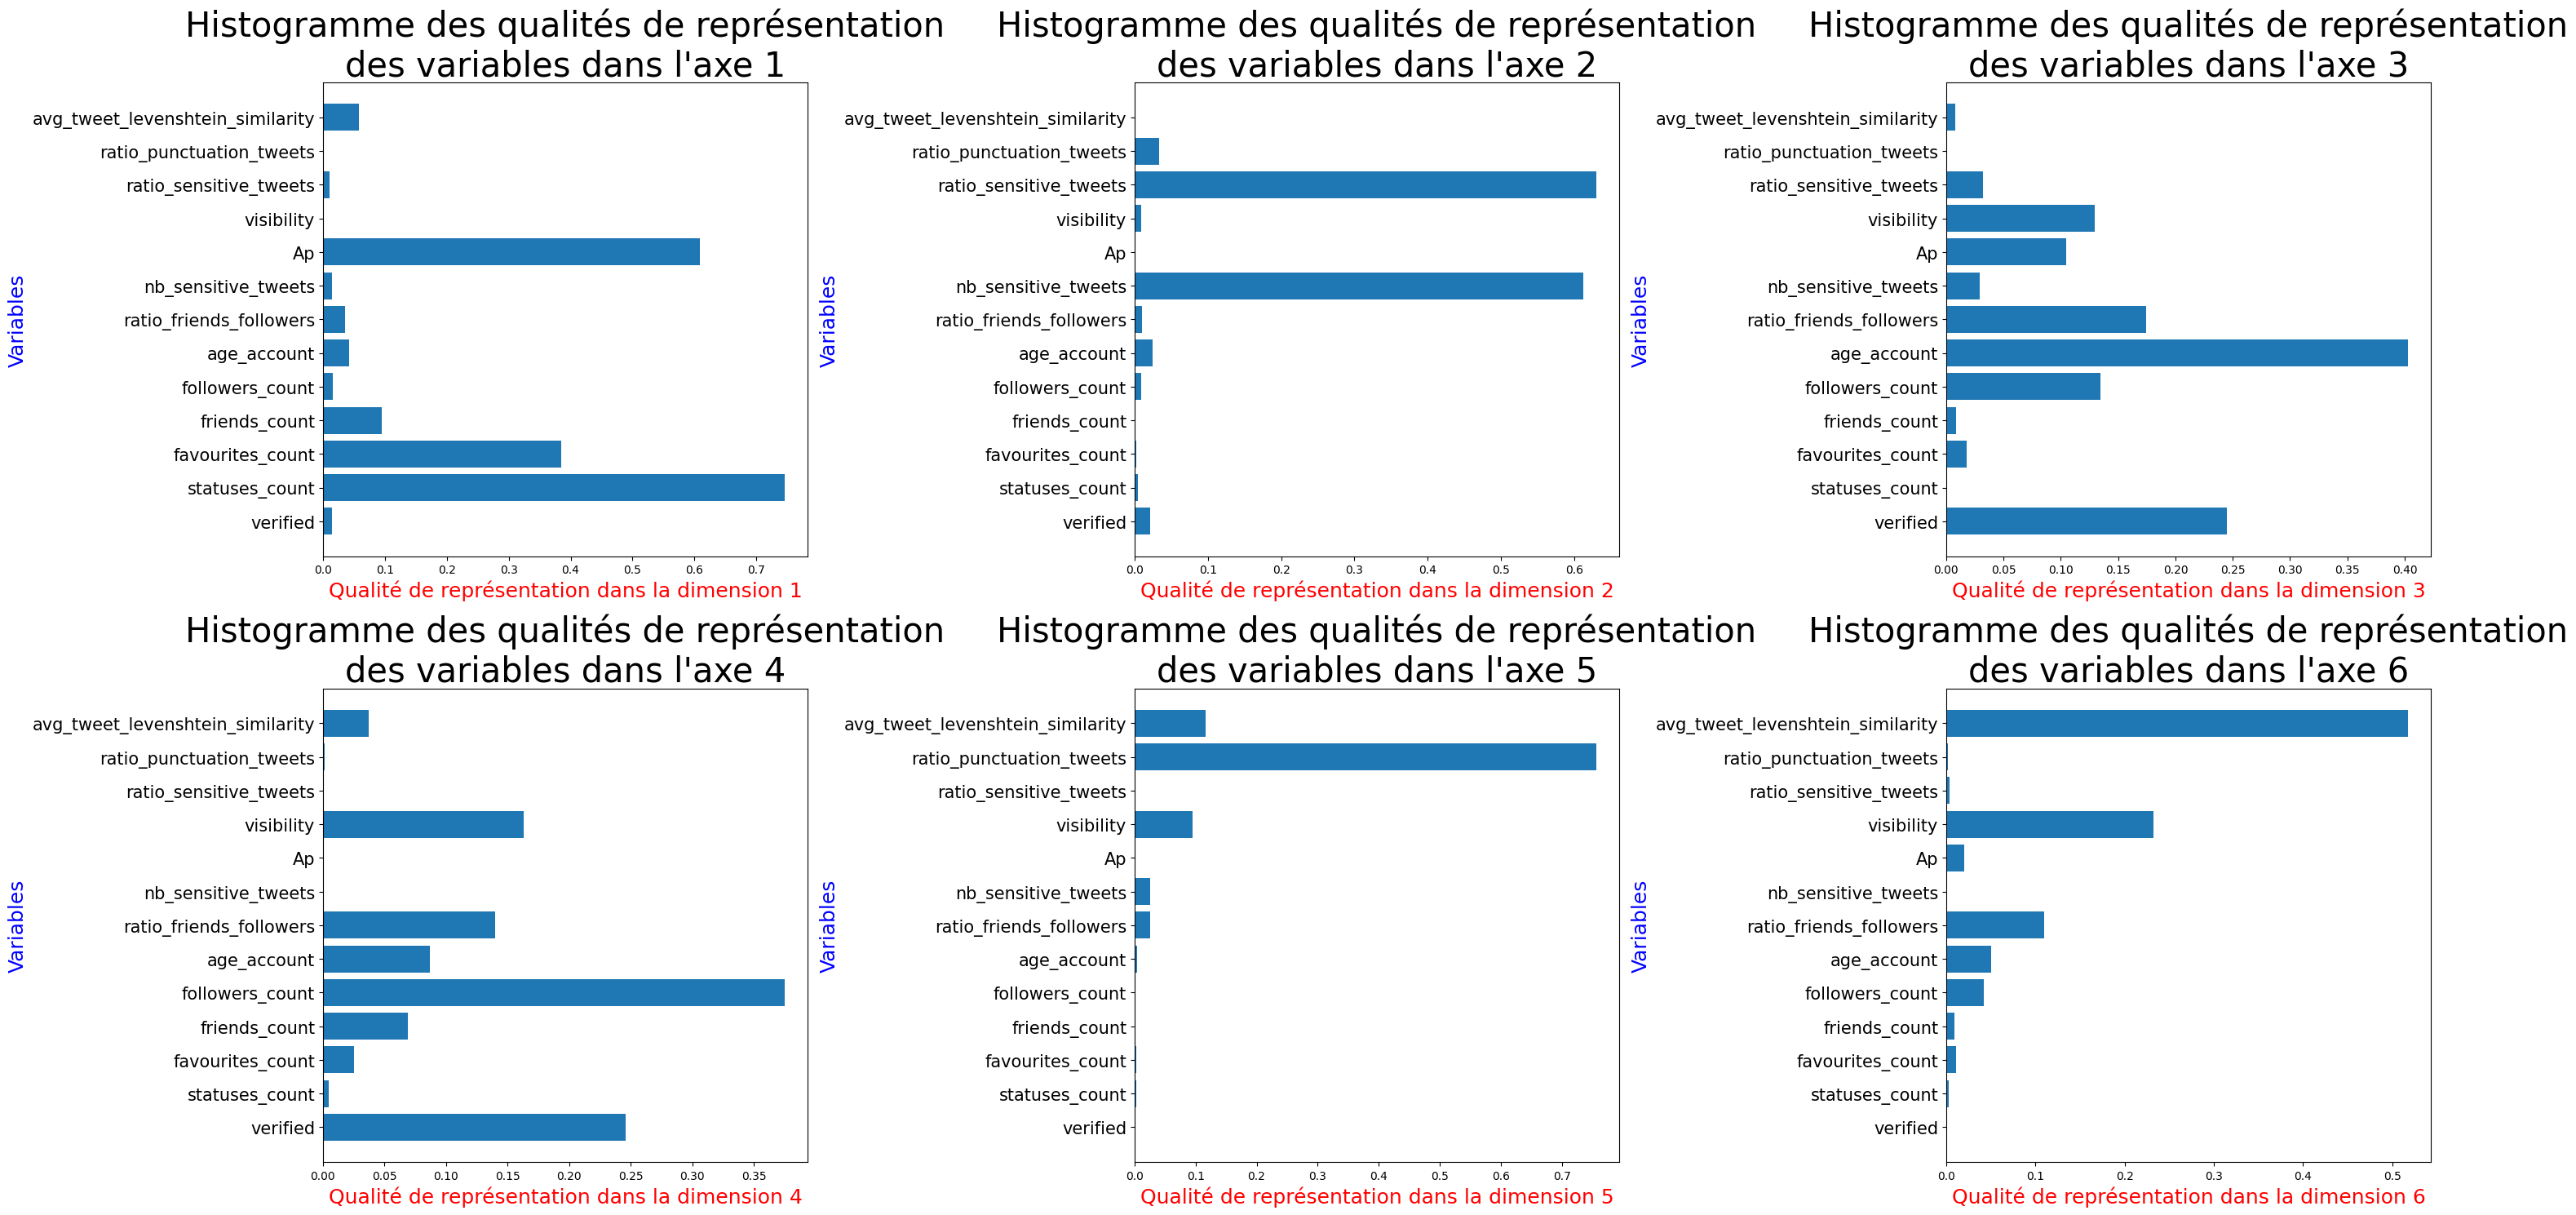

In [18]:
# Qualité de représentation des variables - COS2
cos2 = corr_var**2
var_quali_df = pd.DataFrame({f'COS2_{acp_dim+1}':cos2[:,acp_dim] for acp_dim in range(nb_composante)}, index=users.columns)


cols = 3
rows = math.ceil( (nb_composante - 1) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(30,15))

row = 0
col = -1
num_var = np.arange(len(var_quali_df))

for quali in range(len(var_quali_df.columns)):
    col += 1
    # les points
    axes[row][col].barh(num_var, var_quali_df[f'COS2_{quali+1}'], align='center')
    axes[row][col].set_yticks(num_var)
    axes[row][col].set_yticklabels(var_quali_df.index, fontsize = 15)
    axes[row][col].set_title(f'Histogramme des qualités de représentation\ndes variables dans l\'axe {quali+1}', fontsize=30)
    axes[row][col].set_xlabel(f'Qualité de représentation dans la dimension {quali+1}', fontsize=18, color = 'red')
    axes[row][col].set_ylabel(f'Variables', fontsize=18, color ='blue')
    if col % cols == cols - 1:
        col = -1
        row += 1

fig.tight_layout()
plt.show()